# Sugar Mama's Creamery
Hang Nguyen | 11/14/2017

### Goal: 

The goal of this project is to propose recommendations on how to open a successful ice cream shop. It will aim to answer the question: 

**What makes a great ice cream shop?** 

Using NLP techniques, this project looks at reviews from the Foursquare API to create a model that can predict whether an ice cream shop is highly rated or not. 

### Risks
- Foursquare is a dated application, not everyone uses it
- Ratings/reviews could be skewed depending on whether a shop is marketing Foursquare to users or not
- Not everyone writes reviews
- What constitutes as a bad review? There might not be any bad reviews at all, doesn't give the whole picture
- Not enough ice cream shops
- Not enough reviews for a shop

### Hypothesis:

Ice cream shops are successful if they have:
- good/exciting flavors
- good texture
- fair pricing
- fast and friendly customer service
    
### Data:
- 163 stores around the country in major cities
- 8,500 reviews from these stores from Foursquare
- Rating from 5.7-9.5

### Assumptions:
- Defining "great ice cream store" as stores with ratings that is in top 25% > 8.8
- Defining "bad ice cream store" as stores with ratings that is in the bottom 25% < 7.3

### Investigate:
- Of the data that we have, what's the split of reviews? 
- Are ratings influenced by # of users/#of tips? Looks like some relationship
- Does each city have different standards of ratings?

In [91]:
import json, requests
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, auc #area under curve
from wordcloud import WordCloud


# Getting the Data

Using the Foursquare API, we needed to create three tables - the location table, the tips (aka reviews) table, and the ratings table. 

To create the tips and ratings table, we needed to first create the location table to get each venue's id. 

### Building the Location Table

To build the location table, we wrote a few functions to 1) make a request to the api 2) convert the data from json data to a pandas dataframe. 

In [3]:
#this function takes in an end point and a set of params and makes a request to an API
def request_data(end_point, params):
    params = params
    resp = requests.get(url=end_point, params=params)
    data = json.loads(resp.text)
    print(end_point)
    return data


In [5]:
#this is a function that formats the json data returned by the API request and puts it into a list of dictionaries. 
def make_location_table(data):
    #create an empty list
    lst = []
    
    #loop through each venue in the response list and create a list of dictionaries
    for each in range(len(data['response']['venues'])):
        dct = {}
        dct['venue_id'] = data['response']['venues'][each]['id']
        dct['name'] = data['response']['venues'][each]['name']
        dct['total_checkins'] = data['response']['venues'][each]['stats']['checkinsCount']
        dct['total_users'] = data['response']['venues'][each]['stats']['usersCount']
        dct['tip_count'] = data['response']['venues'][each]['stats']['tipCount']
    
    #use try and except to pass any values that are none
        try:
            dct['address'] = data['response']['venues'][each]['location']['address']
        except:
            dct['address'] = 'None'

        try:
            dct['city'] = data['response']['venues'][each]['location']['city']
        except:
            dct['city'] = None

        try:
            dct['state'] = data['response']['venues'][each]['location']['state']
        except:
            dct['city'] = None    
            
        try:   
            dct['zipcode'] = data['response']['venues'][each]['location']['postalCode']
        except:
            dct['zipcode'] = 'None'

        try:
            dct['lat'] = data['response']['venues'][each]['location']['lat']
        except:
            dct['lat'] = 'None'

        try:
            dct['long'] = data['response']['venues'][each]['location']['lng']
        except:
            dct['long'] = 'None'

        lst.append(dct)

    #create a new dataframe 
    new_df = pd.DataFrame(lst, columns = ['venue_id', 'name', 'address', 'city', 'state', 
                                               'zipcode', 'lat', 'long', 'total_checkins',
                                               'total_users', 'tip_count'])
    return new_df


In [6]:
#use the client_id and client_secret API key 
client_id = 'WJZHVEFVUBTJ1XO42NH5GKWBFV2OQG0JQ11SYKBPRGX5I1BN'
client_secret ='2V3GYPYAK5BMS4NLSWZLTGL2IEZ51524J1CQDHW5ME1DXQUN'

search_endpoint = 'https://api.foursquare.com/v2/venues/search'

#create an empty dataframe
location_table = pd.DataFrame()

#compile a list of locations to search for ice cream venues
near = [
    'New York, NY',
    'Brooklyn, NY',
    'Harlem, NY',
    'Lower East Side, NY',
    'East Village, NY',
    'Greenwich Village, NY',
    'Brooklyn Heights, NY',
    'Soho, NY', 
    'San Francisco, CA',
    'Soma, CA',
    'Mission District, San Francisco',
    'Los Angeles, CA',
    'Santa Monica, CA',
    'Hollywood, CA', 
    'Portland, OR',   
    'Oakland, CA', 
    'Berkeley, CA',  
    'Long Beach, CA', 
    'Seattle, WA',     
    'Boston, MA',
    'Jamaica Plain, MA',
    'Brookline, MA',
    'Cambridge, MA',
    'Austin, TX'
]



#using the two functions above, loop through the near list to compile the location table

for location in near:
    search_params = dict(
        client_id=client_id,
        client_secret=client_secret,
        v='20171114',
        near = location,
        query='ice cream',
        limit=50,
        intent = 'browse')
    data = request_data(search_endpoint, search_params)
    new_df = make_location_table(data)
    
    #concat the location_table with dataframe created for each new location to get one location table
    location_table = pd.concat([location_table, new_df], axis =0, ignore_index = True)


https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/venues/search
https://api.foursquare.com/v2/ve

In [7]:
#clean the dataframe:

#remove duplicate venues in table
location_table = location_table.drop_duplicates(subset= 'venue_id', keep = 'first')

In [8]:
#drop rows where number of tips = 0 and checkins = 0
location_table = location_table[(location_table['tip_count'] != 0) 
                                & (location_table['total_checkins'] != 0) ]


In [9]:
#there are a bunch of places that are not ice cream venues and shouldn't be on here, remove them

remove_indexes = \
            location_table.name[location_table.name.str.contains(
                    "Ice [Ss]kating|Ice [Rr]ink|[Ss][haved]|Hockey|Icebreaker|Arena|Museum|Disney|NBC|\
                Union Square|Fish|Slush|Italian Ice|Center|Oakland Ice Center|Waterloo|Ice Kingdom|Cybelle|Lounge|\
                Cupcake|Grocery|[Ff][iI][Rr][Ee] [&+] [Ii][Cc][Ee]|Picco|Quincy|Angora|Social Bus|Water-Ice|Chaparral")].index

location_table.drop(remove_indexes, axis =0, inplace = True)

In [10]:
#construct the venue id list from location_table
venue_ids_lst = location_table['venue_id']
venue_ids_lst.head()

2     537cd1bb498e956dc853b6a4
5     3fd66200f964a52033eb1ee3
6     4c8e2f1e1664b1f7580c9e2f
8     4cc07b8900d8370444e24a5c
10    518ad7d1454aeee512a0f518
Name: venue_id, dtype: object

### Building the vendor rating table

In [11]:
#create params for the rating table

rating_params = dict(
  client_id=client_id,
  client_secret=client_secret,
  v='20171114')

In [12]:
#create an empty list to store the ratings dictionary
ratings_lst = []

for venue_id in venue_ids_lst:
    rating_endpoint = 'https://api.foursquare.com/v2/venues/{}'.format(venue_id)
    data = request_data(rating_endpoint, rating_params)
    #make the dictionary
    dct = {}
    try:
        dct['name'] = data['response']['venue']['name']
    except:
        dct['name'] = None

    dct['venue_id'] = data['response']['venue']['id']
    
    try:
        dct['rating'] = data['response']['venue']['rating']
    except:
        dct['rating'] = None
    
    #append to ratings list
    ratings_lst.append(dct)
    
#turn list of dicts into df
ratings_table = pd.DataFrame(ratings_lst, columns = ['venue_id', 'name', 'rating'])

https://api.foursquare.com/v2/venues/537cd1bb498e956dc853b6a4
https://api.foursquare.com/v2/venues/3fd66200f964a52033eb1ee3
https://api.foursquare.com/v2/venues/4c8e2f1e1664b1f7580c9e2f
https://api.foursquare.com/v2/venues/4cc07b8900d8370444e24a5c
https://api.foursquare.com/v2/venues/518ad7d1454aeee512a0f518
https://api.foursquare.com/v2/venues/56db5ad2498e66632d8adbec
https://api.foursquare.com/v2/venues/4da9e90da86e771ea7178471
https://api.foursquare.com/v2/venues/5780775a498eb55b2973ce2c
https://api.foursquare.com/v2/venues/55877ae9498ee57015ef8d23
https://api.foursquare.com/v2/venues/5973b09eb9ac383dd3d1ec85
https://api.foursquare.com/v2/venues/49f3daf9f964a520e86a1fe3
https://api.foursquare.com/v2/venues/582dce98fd27163e8350257f
https://api.foursquare.com/v2/venues/4a50f27ef964a5204bb01fe3
https://api.foursquare.com/v2/venues/571d2ced498e590d68ee74ae
https://api.foursquare.com/v2/venues/576f2c3c498e0917af14bc65
https://api.foursquare.com/v2/venues/4d977255c19fb60c42179765
https://

https://api.foursquare.com/v2/venues/4b58cf91f964a520566c28e3
https://api.foursquare.com/v2/venues/4f238286e4b0b653a2a28b55
https://api.foursquare.com/v2/venues/4d8166c01ec4224b83b7c792
https://api.foursquare.com/v2/venues/4bc963df511f9521cfbaadc7
https://api.foursquare.com/v2/venues/4c4c9d3ca34b2d7f7211fd97
https://api.foursquare.com/v2/venues/58dc3cb5e9233e27bf363309
https://api.foursquare.com/v2/venues/4be1cd55a145c928cc9f4e80
https://api.foursquare.com/v2/venues/4a60f584f964a5208dc11fe3
https://api.foursquare.com/v2/venues/4a64ac65f964a52073c61fe3
https://api.foursquare.com/v2/venues/4fa8896ae4b08ab44f9c353c
https://api.foursquare.com/v2/venues/4f4aba4ce4b007d3911e020a
https://api.foursquare.com/v2/venues/55ff3220498ed5a54508d4ea
https://api.foursquare.com/v2/venues/55adc93b498e2f5da4d33f30
https://api.foursquare.com/v2/venues/4ab843bcf964a520c67c20e3
https://api.foursquare.com/v2/venues/4c253d50b012b7139fa60893
https://api.foursquare.com/v2/venues/4aac3297f964a520cf5c20e3
https://

In [13]:
ratings_table.head()

,venue_id,name,rating
0,537cd1bb498e956dc853b6a4,Morgenstern's Finest Ice Cream,9.1
1,3fd66200f964a52033eb1ee3,The Original Chinatown Ice Cream Factory 華埠雪糕行...,9.2
2,4c8e2f1e1664b1f7580c9e2f,Van Leeuwen Ice Cream Truck - 6th,7.2
3,4cc07b8900d8370444e24a5c,Van Leeuwen Ice Cream Truck - 23rd,NaN
4,518ad7d1454aeee512a0f518,Davey's Ice Cream,9.2


In [14]:
#concat location table with ratings table
df = location_table.merge(ratings_table, on='venue_id', how='inner', suffixes=('_1', '_2'))
df.drop("name_2", inplace=True, axis = 1)

In [15]:
df.head()

,venue_id,name_1,address,city,state,zipcode,lat,long,total_checkins,total_users,tip_count,rating
0,537cd1bb498e956dc853b6a4,Morgenstern's Finest Ice Cream,2 Rivington St,New York,NY,10002,40.721597,-73.993160,13528,7995,401,9.1
1,3fd66200f964a52033eb1ee3,The Original Chinatown Ice Cream Factory 華埠雪糕行...,65 Bayard St,New York,NY,10013,40.715599,-73.998202,21864,13680,431,9.2
2,4c8e2f1e1664b1f7580c9e2f,Van Leeuwen Ice Cream Truck - 6th,6th Ave.,New York,NY,10010,40.742337,-73.993279,446,175,4,7.2
3,4cc07b8900d8370444e24a5c,Van Leeuwen Ice Cream Truck - 23rd,23rd St.,New York,NY,None,40.741761,-73.988555,564,335,7,NaN
4,518ad7d1454aeee512a0f518,Davey's Ice Cream,137 1st Ave,New York,NY,10003,40.727839,-73.985173,6940,4003,154,9.2


In [16]:
#rename name_1 column to name
df.rename(columns ={"name_1": "name"}, inplace = True)

In [17]:
#sort out the nulls
df = df[~df.rating.isnull()]

In [18]:
#let's clean up that one last null
df.loc[df[df.city.isnull()].index,'city'] = 'Los Angeles'
df.isnull().sum()

venue_id          0
name              0
address           0
city              0
state             0
zipcode           0
lat               0
long              0
total_checkins    0
total_users       0
tip_count         0
rating            0
dtype: int64

In [19]:
#change one California row to CA
df['state'] = df['state'].replace(to_replace = "California", value = "CA")
df.state.value_counts()

CA    72
NY    52
MA    21
TX    17
WA    16
OR     8
Name: state, dtype: int64

In [20]:
#drop that Fire & Ice!!!
df = df.drop(df[df.name.str.contains('FiRE')].index, axis =0)

### Building the Tips Table:

In [21]:
tips_params = dict(
  client_id=client_id,
  client_secret=client_secret,
  v='20171114', limit = 500)

#reset venue list:
venue_ids_lst = df['venue_id']
venue_ids_lst.shape

(186,)

In [22]:
#make function that builds tips tables
def make_tips_table(data, venue_id):
    lst = []
 
    for tip in range(len(data['response']['tips']['items'])):
        dct = {}
        dct['venue_id'] = venue_id
        dct['tip_id'] = data['response']['tips']['items'][tip]['id']
        
        #Seconds since epoch when their tip was created.
        dct['created_date'] = data['response']['tips']['items'][tip]['createdAt']
        dct['agree_count'] = data['response']['tips']['items'][tip]['agreeCount']
        dct['disagree_count'] = data['response']['tips']['items'][tip]['disagreeCount']
        dct['user_gender'] = data['response']['tips']['items'][tip]['user']['gender']
        dct['tip_text'] = data['response']['tips']['items'][tip]['text']

        lst.append(dct)

    new_df = pd.DataFrame(lst, columns = ['venue_id','tip_id', 'created_date', 'agree_count', 'disagree_count',
                                              'user_gender', 'tip_text'])
        
    return new_df

In [23]:
#create the tips table

tips_table = pd.DataFrame()

for venue_id in venue_ids_lst:
    tips_endpoint = 'https://api.foursquare.com/v2/venues/{}/tips'.format(venue_id)
    data = request_data(tips_endpoint, tips_params)
    new_df = make_tips_table(data, venue_id)
    tips_table = pd.concat([tips_table, new_df], axis = 0, ignore_index=False)

https://api.foursquare.com/v2/venues/537cd1bb498e956dc853b6a4/tips
https://api.foursquare.com/v2/venues/3fd66200f964a52033eb1ee3/tips
https://api.foursquare.com/v2/venues/4c8e2f1e1664b1f7580c9e2f/tips
https://api.foursquare.com/v2/venues/518ad7d1454aeee512a0f518/tips
https://api.foursquare.com/v2/venues/56db5ad2498e66632d8adbec/tips
https://api.foursquare.com/v2/venues/4da9e90da86e771ea7178471/tips
https://api.foursquare.com/v2/venues/5780775a498eb55b2973ce2c/tips
https://api.foursquare.com/v2/venues/55877ae9498ee57015ef8d23/tips
https://api.foursquare.com/v2/venues/5973b09eb9ac383dd3d1ec85/tips
https://api.foursquare.com/v2/venues/49f3daf9f964a520e86a1fe3/tips
https://api.foursquare.com/v2/venues/582dce98fd27163e8350257f/tips
https://api.foursquare.com/v2/venues/4a50f27ef964a5204bb01fe3/tips
https://api.foursquare.com/v2/venues/571d2ced498e590d68ee74ae/tips
https://api.foursquare.com/v2/venues/576f2c3c498e0917af14bc65/tips
https://api.foursquare.com/v2/venues/4d977255c19fb60c42179765/

https://api.foursquare.com/v2/venues/51d77969498ebf3e103c1e6f/tips
https://api.foursquare.com/v2/venues/4a8a198ff964a520e00920e3/tips
https://api.foursquare.com/v2/venues/4d0d9c6e3bbaa1430d373eda/tips
https://api.foursquare.com/v2/venues/4bf8381a5ec320a1135f88d3/tips
https://api.foursquare.com/v2/venues/55c46157498e9438593ea7c7/tips
https://api.foursquare.com/v2/venues/4b6f630af964a5205aee2ce3/tips
https://api.foursquare.com/v2/venues/544f146d498e56fb6c2231ec/tips
https://api.foursquare.com/v2/venues/555906f0498e63ff8da0af72/tips
https://api.foursquare.com/v2/venues/4c27ea7697d00f47a0283fea/tips
https://api.foursquare.com/v2/venues/49f3a8b6f964a520d06a1fe3/tips
https://api.foursquare.com/v2/venues/4a661356f964a520f4c71fe3/tips
https://api.foursquare.com/v2/venues/4eb46445722e578a4efe4694/tips
https://api.foursquare.com/v2/venues/49b84ec4f964a5203f531fe3/tips
https://api.foursquare.com/v2/venues/527ead51498e9cdc232bc428/tips
https://api.foursquare.com/v2/venues/4b09e2d8f964a520301f23e3/

In [24]:
tips_table.shape

(8501, 7)

### Data acquired!

And so concludes our data acquisition stage. At this point, we now have two tables: df (combined location table and ratings table), and tips_table. These are two tables we'll be working with for the rest of the analysis. 

In [25]:
df.head()

,venue_id,name,address,city,state,zipcode,lat,long,total_checkins,total_users,tip_count,rating
0,537cd1bb498e956dc853b6a4,Morgenstern's Finest Ice Cream,2 Rivington St,New York,NY,10002,40.721597,-73.993160,13528,7995,401,9.1
1,3fd66200f964a52033eb1ee3,The Original Chinatown Ice Cream Factory 華埠雪糕行...,65 Bayard St,New York,NY,10013,40.715599,-73.998202,21864,13680,431,9.2
2,4c8e2f1e1664b1f7580c9e2f,Van Leeuwen Ice Cream Truck - 6th,6th Ave.,New York,NY,10010,40.742337,-73.993279,446,175,4,7.2
4,518ad7d1454aeee512a0f518,Davey's Ice Cream,137 1st Ave,New York,NY,10003,40.727839,-73.985173,6940,4003,154,9.2
5,56db5ad2498e66632d8adbec,Minus Celsius Ice Cream,302 Grand St Ste E,New York,NY,10002,40.717498,-73.991413,570,493,15,7.2


In [26]:
tips_table.head()

,venue_id,tip_id,created_date,agree_count,disagree_count,user_gender,tip_text
0,537cd1bb498e956dc853b6a4,543d2c64498e60ae0ab62947,1413295204,5,0,none,"Try the eggless, low-sugar, low-butterfat, yet..."
1,537cd1bb498e956dc853b6a4,5893e140fad9dc56b7888c72,1486086464,2,0,male,There's something amazing about the ice cream ...
2,537cd1bb498e956dc853b6a4,59101dbb8194fc3de97c559d,1494228411,2,0,female,Worth the wait! Extremely creamy burnt vanilla...
3,537cd1bb498e956dc853b6a4,55b61071498ebf87a3459ea6,1437995121,2,0,female,"""Vietnamese coffee and burnt vanilla are reall..."
4,537cd1bb498e956dc853b6a4,58fc2e53f0ca9513846399b7,1492921939,1,0,none,The most delicious ice-cream in New York in my...


# It's time for EDA!

Let's do some eda: we'll look at:

1. Distribution of total checkins, total users, tip count, and rating to see if there's any thing unusual
2. Any differences in these features by state
3. Correlation between these features and our target (the rating)

In [34]:
df.describe()

,lat,long,total_checkins,total_users,tip_count,rating
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,39.044773,-100.205032,3186.774194,1872.860215,46.602151,8.049462
std,4.633769,22.815422,5849.031747,3196.473983,86.662082,0.965807
min,30.161288,-122.699762,31.000000,27.000000,1.000000,5.400000
25%,37.746304,-122.314328,436.250000,285.250000,6.000000,7.400000
50%,40.617080,-118.187491,1109.000000,713.000000,15.000000,8.200000
75%,40.798846,-73.991678,3121.500000,1867.000000,42.750000,8.900000
max,47.682633,-71.053873,47283.000000,25787.000000,673.000000,9.500000


In [30]:
#let's explore total_users and zoom in:

def eda_plots(feature, range_1, bins=30):
    plt.hist(feature, bins =bins )
    plt.show()
    plt.hist(feature, range = range_1, bins = bins)
    plt.show()
    plt.scatter(x = feature.index, y = feature)
    plt.show()
    sns.boxplot(feature)
    plt.show()


# Total Checkins

Summary:
- Most locations are below 10,000
- Everything above 10,000 are outliers
- Average is 3000
- Location by state does not affect total checkins

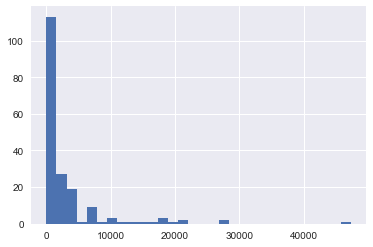

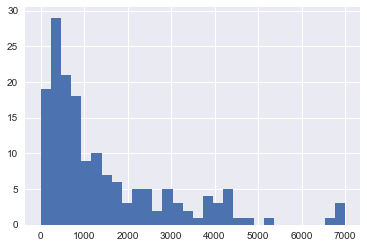

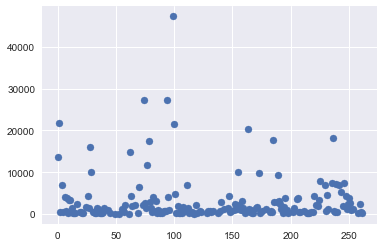

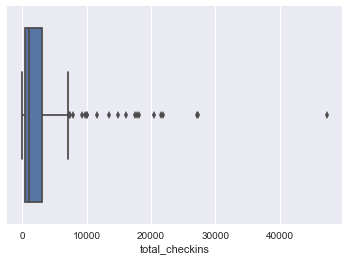

In [31]:
eda_plots(df.total_checkins, range_1 = [0,7000])

In [45]:
#let's look at these outliers
outliers = df[df.total_checkins >7000]


#outliers look like places that have been around for a long time

,venue_id,name,address,city,state,zipcode,lat,long,total_checkins,total_users,tip_count,rating
0,537cd1bb498e956dc853b6a4,Morgenstern's Finest Ice Cream,2 Rivington St,New York,NY,10002,40.721597,-73.993160,13528,7995,401,9.1
1,3fd66200f964a52033eb1ee3,The Original Chinatown Ice Cream Factory 華埠雪糕行...,65 Bayard St,New York,NY,10013,40.715599,-73.998202,21864,13680,431,9.2
28,4abd01bbf964a5200a8820e3,Brooklyn Ice Cream Factory,1 Water St,Brooklyn,NY,11201,40.703184,-73.994706,16143,13380,172,8.8
29,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,175 Kent Ave,Brooklyn,NY,11249,40.718194,-73.963985,10099,6064,220,9.2
62,49bf289bf964a5200a551fe3,Cafe Cluny,284 W 12th St,New York,NY,10014,40.737407,-74.003973,14902,9353,247,9.2
74,4d964291daec224b08b9123e,Smitten Ice Cream,432 Octavia St #1A,San Francisco,CA,94102,37.776286,-122.424195,27206,14682,332,9.3
77,4eac41a5dab40d132703fc44,The Ice Cream Bar Soda Fountain,815 Cole St,San Francisco,CA,94117,37.766435,-122.450171,11657,6451,196,9.3
78,49e22ce6f964a520f9611fe3,Mitchell's Ice Cream,688 San Jose Avenue,San Francisco,CA,94110,37.744135,-122.422813,17476,9378,250,9.2
94,49ba70ecf964a52063531fe3,The Creamery,685 4th St,San Francisco,CA,94107,37.777373,-122.395155,27233,9852,210,7.9
99,45eaff58f964a5208e431fe3,Bi-Rite Creamery,3692 18th St,San Francisco,CA,94110,37.761452,-122.425835,47283,25787,673,9.5


# Total Users

Summary:
- total users mostly below 1000
- Bi-rite surpasses the rest with 25000 visitors, possibly because it's been around the longest - for 26 years

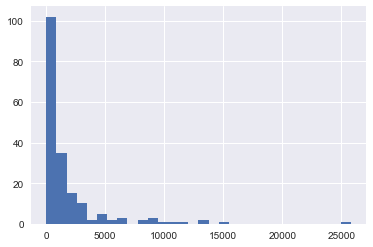

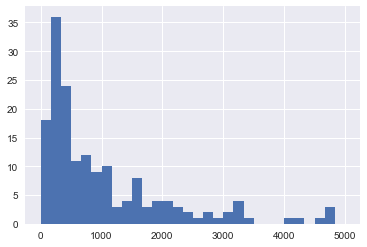

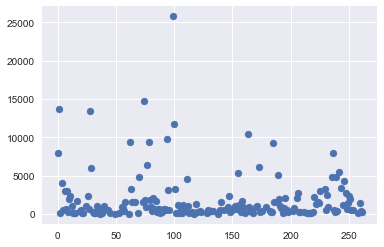

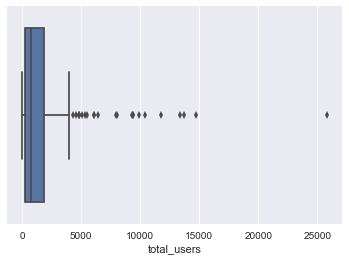

In [37]:
eda_plots(df.total_users, range_1 = [0,5000])

In [48]:
df[df.total_users>25000]

,venue_id,name,address,city,state,zipcode,lat,long,total_checkins,total_users,tip_count,rating
99,45eaff58f964a5208e431fe3,Bi-Rite Creamery,3692 18th St,San Francisco,CA,94110,37.761452,-122.425835,47283,25787,673,9.5


# Tip Counts

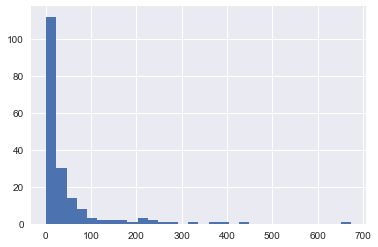

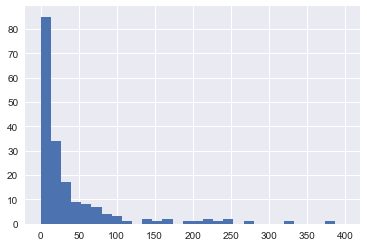

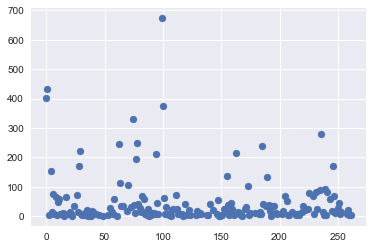

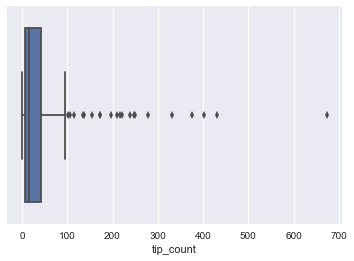

In [42]:
eda_plots(df.tip_count, range_1 = [0,400])

# Ratings

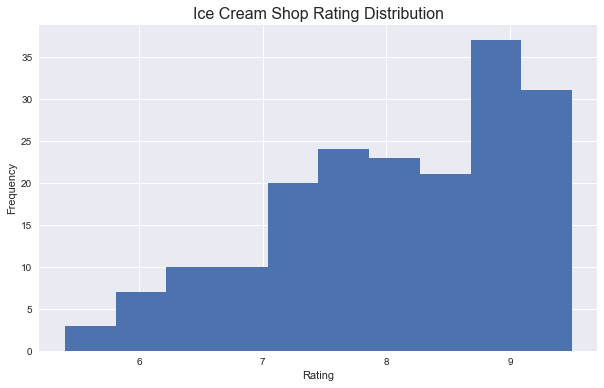

In [1809]:
plt.figure(figsize =(10,6))
plt.hist(df.rating);
plt.title("Ice Cream Shop Rating Distribution",  fontsize='16');
plt.xlabel("Rating");
plt.ylabel("Frequency");

### Compare each feature by state

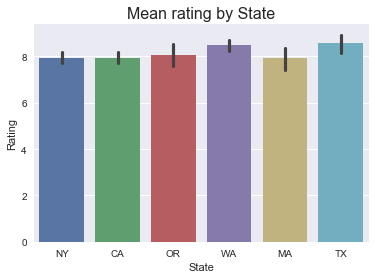

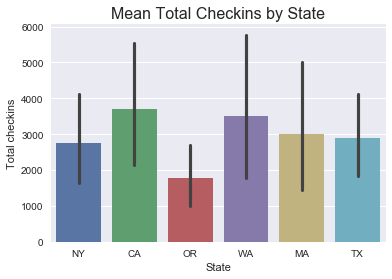

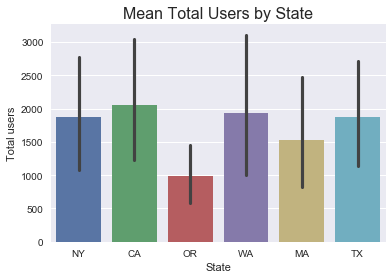

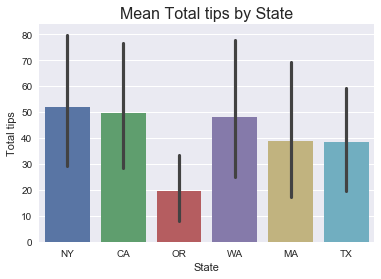

In [44]:
def barplot(x, y, ylabel, title):
    sns.barplot(x = x, y = y)
    plt.xlabel("State")
    plt.ylabel(ylabel)
    plt.title(title, fontsize="16")
    plt.show()
    
barplot(df.state, df.rating, "Rating", 'Mean rating by State')
barplot(df.state, df.total_checkins, "Total checkins", 'Mean Total Checkins by State')
barplot(df.state, df.total_users, "Total users", 'Mean Total Users by State')
barplot(df.state, df.tip_count, "Total tips", 'Mean Total tips by State')

**Summmary**
- looks like there's not much difference in shop ratings by state
- Oregon has the lowest average total tips, total users, and total checkins but perhaps that is a ratio of how big the state is, and that we only took locations from Portland

### Correlations?

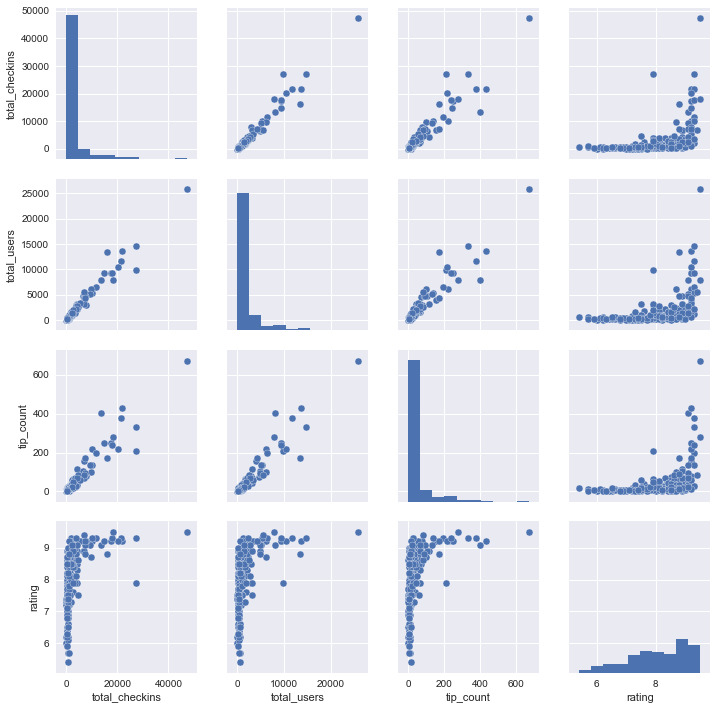

In [1832]:
sns.pairplot(df[plot_columns])

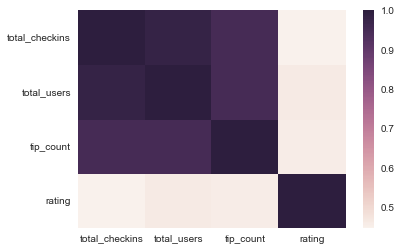

In [1121]:
df_corr = df[['total_checkins', 'total_users', 'tip_count', 'rating']].corr()
sns.heatmap(df_corr)

In [1122]:
tips_table.user_gender.value_counts()

female    4144
male      3629
none       728
Name: user_gender, dtype: int64

# Data Preprocessing: Part 1

Looking at the dataframe that we have, we see that there are a few shops with multiple locations. In order to do any further text analysis, we will want to combine the locations into one row. 

Below, we manuallyfind all the duplicate venues and use a function to average out the ratings, remove all the other rows, and combine it back up with the original dataframe. 

In [50]:
#create a duplicate venues list
duplicate_venues = ['10Below',
                    'Ample Hills',
                    "Amy's",
                    "Ben & Jerry's",
                    'Blossom',
                    'Bluebird',
                    'Brooklyn Ice Cream Factory',
                    'CREAM',
                    'Cafe Cluny',
                    'Carvel Ice Cream',
                    'Carmela',
                    'Cako',
                    'Carmela',
                    'Cold Stone Creamery',
                    "Davey's",
                    'Emack',
                    'Full Tilt',
                    'J.P. Licks',
                    'Little Giant',
                    "Mateo's",
                    "McConnell's",
                    "Molly Moon's",
                    'Smitten',
                    'Sprinkles',
                    "Tara's Organic",
                    'Van Leeuwen']


In [57]:
#put all tips from each venue into one row to form a new dataframe with each row 
#containing a venue_id and a list of strings containing each comment for each venue

text_df = tips_table[['venue_id', 'tip_text']].groupby('venue_id')['tip_text'].apply(list)

In [58]:
#loop through each row in text_df and convert the list of strings into one giant string

dct_list = []
for i in range(0, text_df.shape[0]):
    dct={}
    dct['venue_id'] = text_df.index[i]
    dct['tip_text'] = " ".join(text_df[i])
    dct_list.append(dct)

text_df = pd.DataFrame(dct_list, columns = ['venue_id', 'tip_text'])

In [59]:
#join ratings in with the dataframe
text_df = text_df.merge(df[['venue_id', 'name', 'rating']], on='venue_id', how='inner')

In [60]:
text_df.shape

(186, 4)

In [62]:
text_df.head()

,venue_id,tip_text,name,rating
0,3fd66200f964a52018e71ee3,"A solid ice cream place, I come here for the c...",Cones,8.9
1,3fd66200f964a52033eb1ee3,You will find more than just your typical flav...,The Original Chinatown Ice Cream Factory 華埠雪糕行...,9.2
2,412d2800f964a520c90c1fe3,Check out the rich variety of fresh roasted co...,J.P. Licks Jamaica Plain,9.2
3,42853f80f964a520f7221fe3,Here's the thing with JP Licks. If you don't l...,J.P. Licks Coolidge Corner,8.9
4,43388b80f964a52031281fe3,Ranked the best ice cream shop in all of Massa...,Toscanini's,9.5


In [63]:
#this function takes in a string value for a venue name and the text_df and combines the duplicate venues into one

def replace_duplicate_venues(venue_name, text_df):
    #create a df with just the duplicates
    venue_df = text_df[text_df.name.str.contains(venue_name)].copy()
    #get the mean rating
    mean_rating = venue_df.rating.mean()
    #replace all the venue_id with the first venue_id
    venue_df['venue_id'] = venue_df.iloc[0,0]
    #do a groupby to put all the text in one row
    venue_df = venue_df.groupby('venue_id')['tip_text'].apply(list)
    #change list to string
    venue_df[0] = ''.join(venue_df[0])
    #create a dataframe
    venue_df = pd.DataFrame(venue_df)
    #add the other columns back
    venue_df['name'] = venue_name
    venue_df['rating'] = mean_rating
    #reset index
    venue_df.reset_index(inplace = True)
    #drop all duplicates from text_df 
    text_df = text_df.drop(text_df[text_df.name.str.contains(venue_name)].index, axis = 0)
    #append the new series to text_df
    text_df = text_df.append(venue_df)
    return text_df

for each in duplicate_venues:
    text_df = replace_duplicate_venues(each, text_df)

In [64]:
text_df.shape

(108, 4)

# Data Preprocessing

We're ready to start preprocessing! We know that our target will be the ratings, and the features will be the text reviews. 

Since we only want our model to be able to tell which ice cream is successful and which is not, we've decided to encode the target (ratings) to a binary classification problem thus, we will be encoding any venues with an 8.8 rating or above as 1 and everything else 0.

We will perform the following preprocessing steps so that our data will be ready for modeling:

1. Encode the target ratings - top 25% of shops will = 1, else 0
2. Train test split
3. Text cleaning - stop words, stemming, count vectorizer, tfidf

In [349]:
#create custom stop words list with punctuation

#Import the punctuation list
from string import punctuation
lst_punc = list(set(punctuation))

#open a comprehensive stop words list found online that has 500+ different stop words rather than the 100 
#with the built-in stop words list
for line in open('stop_words_lst.txt', "r"):
    line = line.replace('"', '').strip()
    
my_stopwords = line.split(",")

#add punctuation to stop words:
[my_stopwords.append(each) for each in lst_punc]

#add ice cream to stop words
my_stopwords.append("ice")
my_stopwords.append("cream")

In [350]:
#encode y to top 25% rating is 1, else 0
text_df['rating_encoded'] = text_df['rating'].apply(lambda x: 1 if x >=8.8 else 0)

In [351]:
#reset index
text_df.reset_index(drop = True, inplace = True)

In [352]:
#set y and X
y = text_df['rating_encoded']
X = text_df.drop('rating_encoded', axis =1)

In [353]:
#calculate the baseline
baseline = 1-y.mean()
print('baseline', baseline)

baseline 0.7314814814814814


In [370]:
X.tip_text[2]

'Award-winning French Chef Jacques Torres opened up his first chocolate shop in DUMBO. Chocoholics can now enjoy his mouth-watering works of art at five cozy boutiques throughout the city. This is a place that Willy Wonka would be jealous of. State of the art machines produce perfect morsels of chocolates to eat or buy as gifts for that special someone. Their “wicked” hot chocolate is so good, it hurts. This perfect balance of spicy and sweet is best paired with a gooey chocolate chip cookie. Treat your taste buds to a quality thin, chocolate chip cookie holding together reviving, creamy ice cream made from natural ingredients. Come during spring and summer because it’s only offered then! Ready for dessert? Sweet-tooths flock to Jacques Torres for its ethereal truffles, cookies and European-style hot chocolate, all made on-site at this chocolate factory.  – Green Guide Editor In 2000, Master Pastry Chef Jacque Torres started his chocolate vision right here in DUMBO. Try their famous mu

# Feature Engineering

In [142]:
#word count feature
text_df['word_count'] = text_df.tip_text.apply(lambda x: len(x.split(' ')))

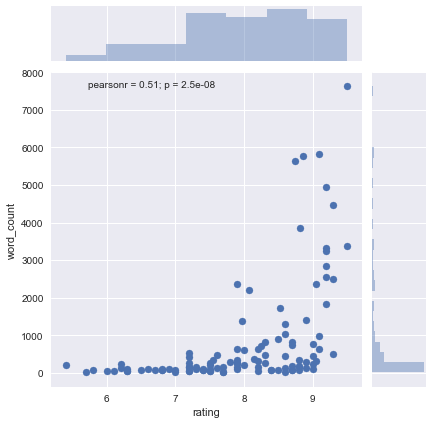

In [151]:
sns.jointplot(x = text_df.rating, y=text_df.word_count);

It's interesting to see that while there are places that are rated 9 and above with less than 1000 words, only places that are rated 9 and above would have a word count of 3000 or above. This tells me that stores can have a higher rating with less reviews but stores that have lots of reviews tend to have higher ratings. 

# Analyzing the text:
### Using LDA, countvectorizer, and tf-idif

Now that we have the data cleaned up a bit, we can go through and see if we can find anything interesting in the text of the reviews.

Can we find data that supports our hypothesis that a succesful ice cream shop has:
- distinct flavors
- fast customer service
- high quality ingredients
- great texture

Here, we use LDA to see if we can find any topics that are common/different among the top 25% and the bottom 25% of venues

In [222]:
#create a dataframe forthe top 25% and the bottom 25% venues. 
#What do they have in common? What are their differences

top_performers = text_df[text_df.rating_encoded ==1].reset_index(drop = True)
bottom_performers = text_df[text_df.rating <7.3].reset_index(drop = True)

(array([ 13.,   2.,   1.,   4.,   4.,   1.,   1.,   2.,   0.,   1.]),
 array([   83. ,   838.3,  1593.6,  2348.9,  3104.2,  3859.5,  4614.8,
         5370.1,  6125.4,  6880.7,  7636. ]),
 <a list of 10 Patch objects>)

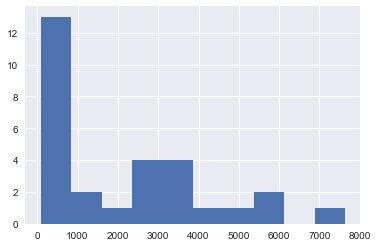

In [224]:
plt.hist(top_performers.word_count)

In [70]:
#does word count correspond to ratings?
top_performers['word_count'] = top_performers.tip_text.apply(lambda x: len(x.split(' ')))

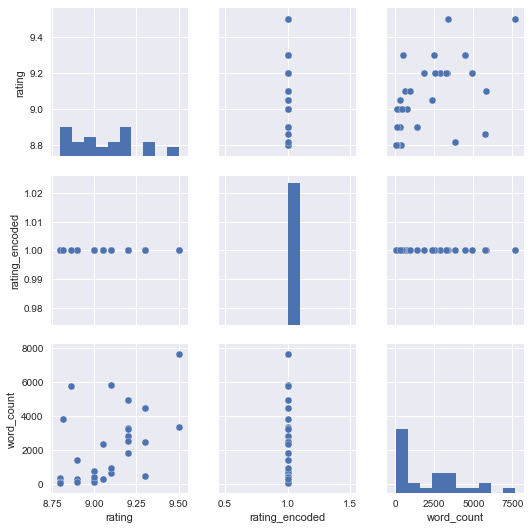

In [71]:
sns.pairplot(top_performers)
#nope!

In [134]:
#this function takes in a dataframe, range of ngrams, and the number of topics and fits an LDA model
def lda_model(df, ngram_range, num_topics):
    cvect = CountVectorizer(stop_words = my_stopwords, ngram_range = (ngram_range))
    X = cvect.fit_transform(df)
    feature_names = cvect.get_feature_names()
    lda = LatentDirichletAllocation(n_topics=num_topics)
    lda.fit(X)
    results = pd.DataFrame(lda.components_,
                      columns=feature_names)
    
    return results

#this function takes in the results from the lda_model, the topic number, 
#the number of words to display, and the background color and prints out a word cloud
def make_wordcloud(topic_results, topic_num, num_words, bkgrd_color):
    word_lst = topic_results.T[topic_num].sort_values(ascending=False).index
    word_string = ' '.join(word_lst[0:num_words])
    wordcloud = WordCloud(background_color = bkgrd_color, 
                         scale = 5).generate(word_string)
    plt.figure(figsize=(12,5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [157]:
tp_results = lda_model(top_performers.tip_text, (2,4), 5)
bp_results = lda_model(bottom_performers.tip_text, (2,4), 5)

/Users/htn211/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/htn211/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


### Top Performer Topics

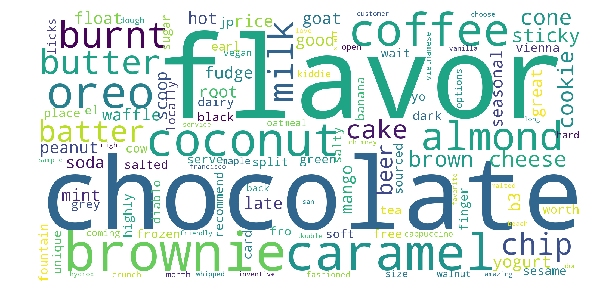

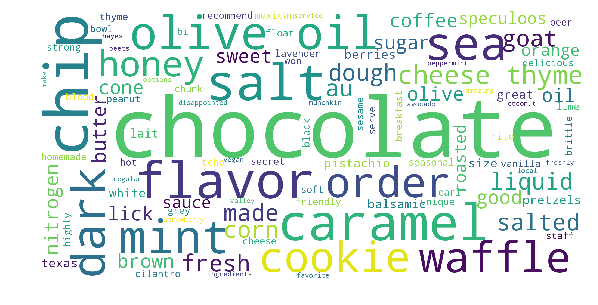

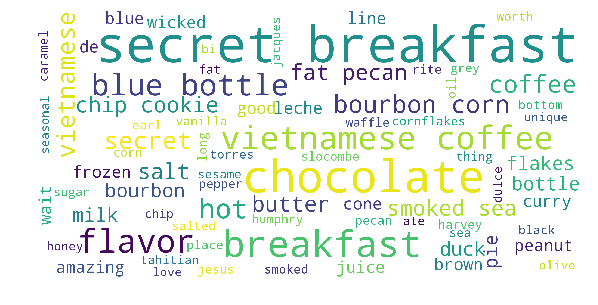

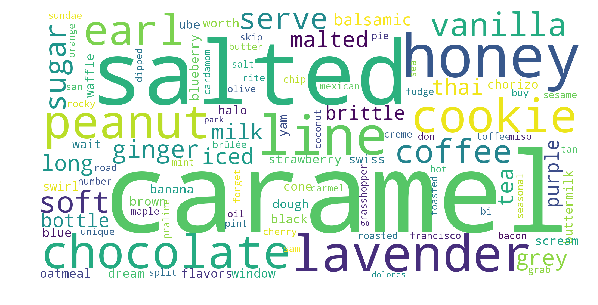

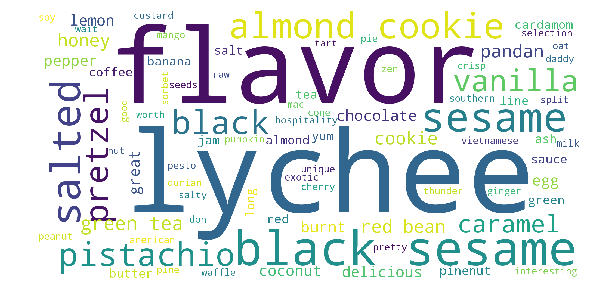

In [158]:
for each in range(tp_results.shape[0]):
    make_wordcloud(tp_results, each, 100, 'white')

### Bottom Performers Topics

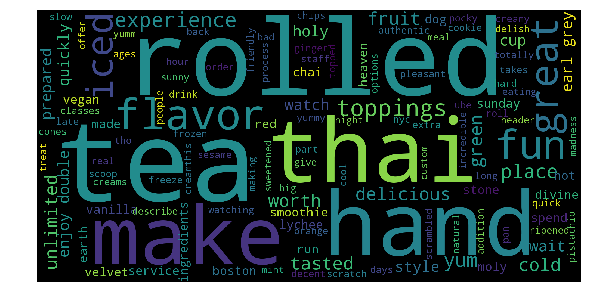

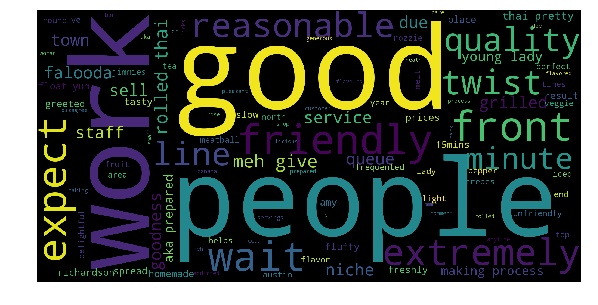

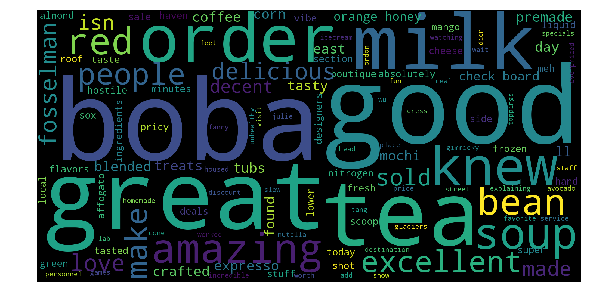

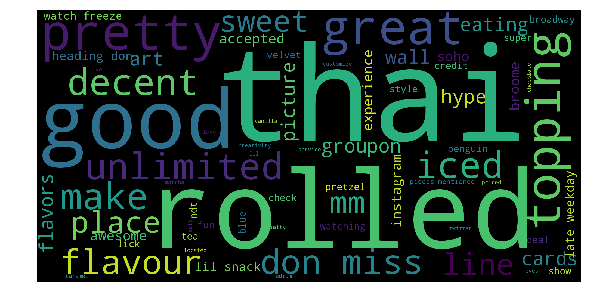

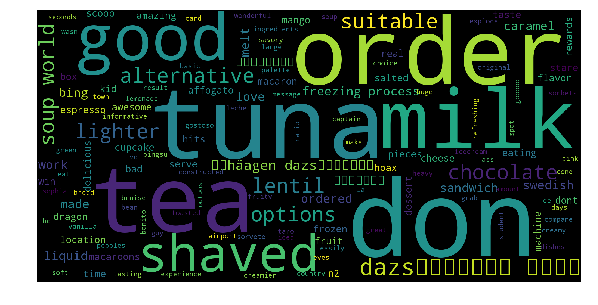

In [159]:
for each in range(bp_results.shape[0]):
    make_wordcloud(bp_results, each, 100, 'black')

This is an interesting finding! The word clouds for the top 25% show mostly words that have to do with ingredients and flavors while the bottom 25% word clouds are not as distinct in words that designate flavors. A telling word cloud is in topic 4 where soup and tuna are the biggest words. This tells me that stores that are in the top 25% specialize in only selling ice cream and that customers care about distinct flavors. Stores in the bottom 25% sell other food products alongside ice cream, and do not have a distinguished menu of ice cream.

In [377]:
vocabulary = ["customer service", "great", "service", "highly recommend",
              "fast", "slow", "line", "wait", "not long", "no line", "long line",
              "ingredients", "ingredient", "local", "locally", "fresh", "quality", 
              'flavors', "texture", "organic",
              "worth", "not worth", "not worth it", "too expensive", "expensive", 
              "overpriced", "amazing", "disappointing"]

def feature_importance(df, ngram_range, vocabulary_list):
    tf = TfidfVectorizer(stop_words = my_stopwords, ngram_range = ngram_range, 
                         vocabulary=vocabulary_list)
    tf.fit(df)

    tf_importance = pd.DataFrame(tf.transform(df).todense(),
                                  columns=tf.get_feature_names())
    print(tf_importance.mean().sort_values(ascending=False))

    return tf_importance

tp_feature_importance = feature_importance(top_performers.tip_text, (1,3), vocabulary)

flavors             0.569220
great               0.331935
amazing             0.316912
line                0.148423
worth               0.138643
wait                0.120703
fresh               0.107695
service             0.081199
organic             0.053498
quality             0.049800
local               0.047699
texture             0.044780
ingredients         0.037392
long line           0.037351
expensive           0.037018
locally             0.032973
slow                0.030344
highly recommend    0.025434
fast                0.018841
customer service    0.018581
overpriced          0.009273
ingredient          0.003878
disappointing       0.001102
not long            0.000000
no line             0.000000
not worth           0.000000
not worth it        0.000000
too expensive       0.000000
dtype: float64


In [378]:
bp_feature_importance = feature_importance(bottom_performers.tip_text, (1,3), vocabulary)

great               0.297712
flavors             0.158701
service             0.120100
amazing             0.110395
line                0.090059
wait                0.089619
worth               0.083872
fresh               0.076519
slow                0.062977
ingredients         0.061792
customer service    0.045571
local               0.043638
texture             0.033811
highly recommend    0.023275
organic             0.022337
overpriced          0.020471
expensive           0.018639
disappointing       0.018639
quality             0.017762
locally             0.000000
ingredient          0.000000
long line           0.000000
no line             0.000000
not long            0.000000
not worth           0.000000
not worth it        0.000000
too expensive       0.000000
fast                0.000000
dtype: float64


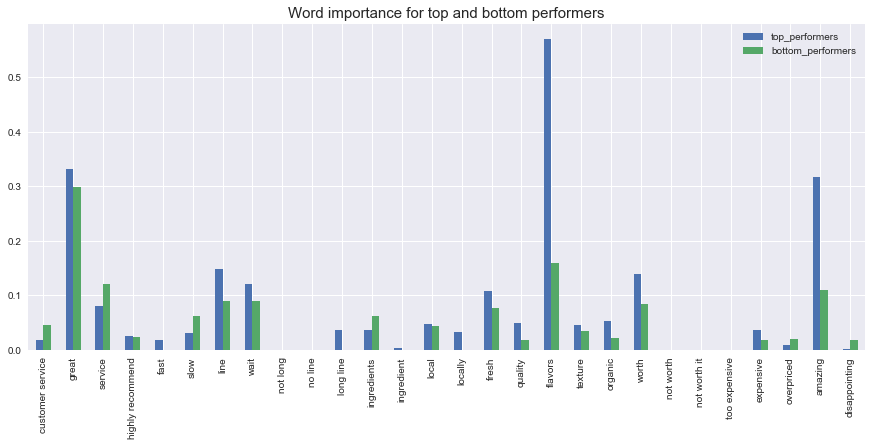

In [379]:
tp_df = pd.DataFrame(tp_feature_importance.mean(), 
             index = tp_feature_importance.columns, columns = ['top_performers'])
bp_df = pd.DataFrame(bp_feature_importance.mean(), 
             index = bp_feature_importance.columns, columns = ['bottom_performers'])

coefs_df = pd.concat([tp_df, bp_df], axis = 1)

coefs_df.plot.bar(figsize=(15,6))
plt.title('Word importance for top and bottom performers', fontsize=(15));

# Modeling

For this problem, we will use classification models. Since we also want high intrepretability, we'll want to stick to the simple models. We'll start with using a Logistic Regression. 

We created a few functions that utilizes pipelines and grid search to help us optimize the model. Since we used tf-idf to dissect the reviews, we'll want to use some sort of regularization techniques such as TruncatedSVD or Lasso to decrease the likelihood of overfitting. 

### Train Test Split


In [380]:
#perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y)

In [381]:
#define the preprocessed dataset
X_train_pp = X_train.tip_text
X_test_pp = X_test.tip_text

In [382]:
#this function takes in a pipeline, gridsearch params, X and y dataframes to fit, score, and predict on a model.

def fit_score_gs_predict(pipe, grid, X_train, y_train, X_test, y_test):
    
    skf = StratifiedKFold(n_splits = 3, random_state = 2017)
    
    gs = GridSearchCV(pipe, grid, verbose =1, n_jobs = -1, cv = skf)
    gs.fit(X_train, y_train)
    predictions = gs.predict(X_test)
    print('best cross-val accuracy', gs.best_score_)
    print('best params', gs.best_params_)
    print('best test accuracy', gs.best_estimator_.score(X_test, y_test))
    print(confusion_matrix(y_test, predictions)) 
    print(classification_report(y_test, predictions)) 
    
    return gs.best_estimator_, predictions

In [405]:
#logistic regression params using a pipeline that has truncated svd

lr = LogisticRegression(random_state = 2017)

grid = {
    'clf__penalty': ['l1'],
    'clf__C': np.linspace(1,1000, 100)
}

pipe = Pipeline(
   [('tf', TfidfVectorizer(stop_words = my_stopwords)), 
    ('trunSVD', TruncatedSVD(n_components = 10)),
    ('clf', lr)])

lr_w_truncated_svd, lr_tsvd_predictions = \
        fit_score_gs_predict(pipe, grid, X_train_pp, y_train, X_test_pp, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.2s finished


best cross-val accuracy 0.791666666667
best params {'clf__C': 303.72727272727275, 'clf__penalty': 'l1'}
best test accuracy 0.833333333333
[[26  0]
 [ 6  4]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.90        26
          1       1.00      0.40      0.57        10

avg / total       0.86      0.83      0.81        36



In [406]:
lr = lr_w_truncated_svd.named_steps['clf']

In [384]:
lr = LogisticRegression(random_state = 2017, penalty = 'l1')

grid_nosvd = {
    'clf__C': [10, 100, 1000],
    'tf__ngram_range': [(2,2)]
}

pipe_nosvd = Pipeline(
   [('tf', TfidfVectorizer(stop_words = my_stopwords, ngram_range = (2,2))), 
    ('clf', lr)])

lr_tf_model, lr_tf_pred = \
        fit_score_gs_predict(pipe_nosvd, grid_nosvd, X_train_pp, y_train, X_test_pp, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.2s finished


best cross-val accuracy 0.708333333333
best params {'clf__C': 10, 'tf__ngram_range': (2, 2)}
best test accuracy 0.805555555556
[[25  1]
 [ 6  4]]
             precision    recall  f1-score   support

          0       0.81      0.96      0.88        26
          1       0.80      0.40      0.53        10

avg / total       0.80      0.81      0.78        36



In [385]:
#model without truncated svd
tf = TfidfVectorizer(stop_words = 'english', ngram_range= (2,2))
lr = LogisticRegression('l1', C = 1000, random_state=2017)
X_train_tf = tf.fit_transform(X_train_pp)
X_test_tf = tf.transform(X_test_pp)

lr_model = lr.fit(X_train_tf, y_train)
predictions = lr.predict(X_test_tf)
print('mean cross val score', np.mean(cross_val_score(lr, X_train_tf, y_train, cv = 3)))
print('std cross val score', np.std(cross_val_score(lr, X_train_tf, y_train, cv = 3)))
print('test accuracy', lr.score(X_test_tf, y_test))
print(confusion_matrix(y_test, predictions)) 
print(classification_report(y_test, predictions)) 

mean cross val score 0.708599033816
std cross val score 0.0306619845501
test accuracy 0.777777777778
[[25  1]
 [ 7  3]]
             precision    recall  f1-score   support

          0       0.78      0.96      0.86        26
          1       0.75      0.30      0.43        10

avg / total       0.77      0.78      0.74        36



(array([  1.,   8.,  11.,  11.,   7.,   2.,   1.,   1.,   1.,   2.]),
 array([-16.2431809 ,  -6.89571316,   2.45175457,  11.79922231,
         21.14669005,  30.49415779,  39.84162552,  49.18909326,
         58.536561  ,  67.88402874,  77.23149647]),
 <a list of 10 Patch objects>)

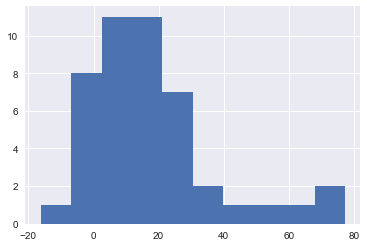

In [386]:
coef = lr.coef_

coef_df = pd.DataFrame(coef, columns = tf.get_feature_names()).T
coef_not_0 = coef_df[0][coef_df[0] !=0]
plt.hist(coef_not_0)

In [387]:
coef_not_0.shape

(45,)

In [388]:
coef_not_0.sort_values().index

Index(['scout mint', 'red velvet', 'molly moon', 'candied bacon', 'spin wheel',
       'fancy nancy', 'yogurt pleasantly', 'shake malted',
       'marionberry forever', 'ice cream', 'cookie dough', 'good amaretto',
       'gelato best', 'coffee cappuccino', 'delicious caffe', 'rice gelato',
       'gelato espresso', 'black sesame', 'gelato delicious', 'caffe umbria',
       'liquid nitrogen', 'espresso affogato', 'cappuccino gelato',
       'secret breakfast', 'salted caramel', 'yummy gelato', 'mint chip',
       'chimney cones', 'yogurt salted', 'mango sticky', 'salted dark',
       'black tan', 'sticky rice', 'caramel salt', 'delicious yogurt',
       'burnt caramel', 'vanilla malt', 'hot chocolate', 'churros leche',
       'halo halo', 'olive oil', 'banana split', 'cookie crisp',
       'flavors available', 'cream cookies'],
      dtype='object')

In [389]:
coef_graph = coef_not_0.sort_values(ascending = False)[0:25]

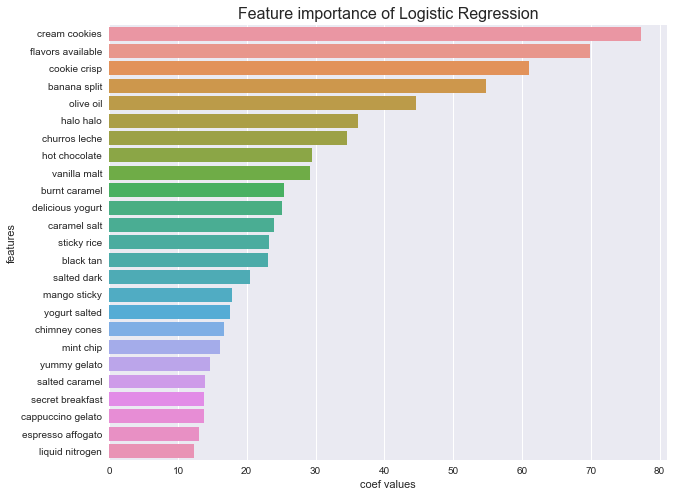

In [394]:
plt.figure(figsize = (10,8))
sns.barplot(x = coef_graph, y = coef_graph.index)
plt.xlabel('coef values')
plt.ylabel('features')
plt.title('Feature importance of Logistic Regression', fontsize=16)
plt.show()


# Evaluating the Model

In [395]:
lr_model.coef_

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [396]:
probability = lr_model.predict_proba(X_test_tf)
predict_proba = pd.DataFrame(probability, columns = ["0", "1"], index = X_test.name).head()

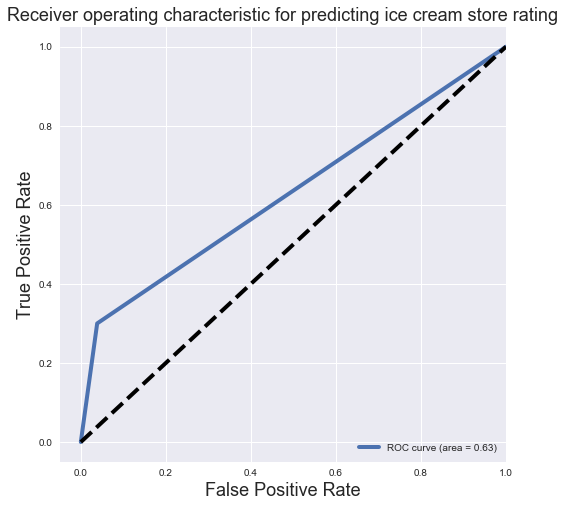

In [397]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for predicting ice cream store rating', fontsize=18)
plt.legend(loc="lower right")
plt.show()

**Summary:**

Our model does not perform that well given an AUC score of 0.63 and an accuracy of ~83 which is 10% better than the baseline. We also see that the top coefs that have the highest impact are all related to flavors, confirming what we found in LDA - that top performers have distinct flavors. 